In [32]:
### Diversity analysis ###
# wt

# "estimateAbundance" function infers a complete clonal abundance distribution.
# "alphaDiversity" function generate a smooth diversity (D) curve is generated over a range of diversity orders (q).
# also test the diverstiy (D) at a fixed diversity order (q).

# Load required packages
library(alakazam)
library(dplyr)
library(scales)
library(ggplot2)
library(shazam)

db <- readChangeoDb("../../changeo_10x/filtered_contig_heavy_germ-pass.tsv", select = NULL, drop = NULL, seq_upper = TRUE)
glimpse(db)

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.



Rows: 4,474
Columns: 62
$ sequence_id               <chr> "AGTCTTTGTAGGGACT-1_contig_2", "ACTATCTTCTG…
$ sequence                  <chr> "GGAAACATATGTCCAATGTCCTCTCCACAATCCCTGAAGACA…
$ rev_comp                  <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ productive                <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, T…
$ v_call                    <chr> "IGHV1-42*01", "IGHV1-42*01", "IGHV1-62-2*0…
$ d_call                    <chr> "IGHD2-3*01", "IGHD4-1*01,IGHD4-1*02", "IGH…
$ j_call                    <chr> "IGHJ3*01", "IGHJ3*01", "IGHJ3*01", "IGHJ3*…
$ sequence_alignment        <chr> "GAGGTCCAGCTGCAGCAGTCTGGACCT...GAGCTGGTGAAG…
$ germline_alignment        <chr> "GAGGTCCAGCTGCAGCAGTCTGGACCT...GAGCTGGTGAAG…
$ junction                  <chr> "TGTGCAGGCTTCTATGATGAGGCCTGGTTTGCTTACTGG", …
$ junction_aa               <chr> "CAGFYDEAWFAYW", "CARLRGWDPFAYW", "CARHEELG…
$ v_cigar                   <chr> "111S291=", "109S294=", "114S302=", "88S293…
$ d_cigar                   

In [33]:
# Upate names in alakazam’s default colors (IG_COLORS)
names(IG_COLORS) <- c( "IGHA", "IGHD", "IGHE", "IGHG", "IGHM","IGHK", "IGHL")
# Subset data to IgM, IgG and IgA
db <- subset(db, c_call %in% c("IGHM","IGHG","IGHA"))

In [34]:
# Partitions the data based on the sample column
clones <- countClones(db, group= "c_call", clone="clone_id")
head(clones, 5)

c_call,clone_id,seq_count,seq_freq
<chr>,<chr>,<int>,<dbl>
IGHM,186_2892,3,0.0008733624
IGHM,2847_41,3,0.0008733624
IGHA,951_448,2,0.1538461538
IGHM,1013_2199,2,0.0005822416
IGHM,1413_717,2,0.0005822416


Warning message in estimateAbundance(db, group = "c_call"):
“Not all groups passed threshold min_n=30. Excluded: IGHA”


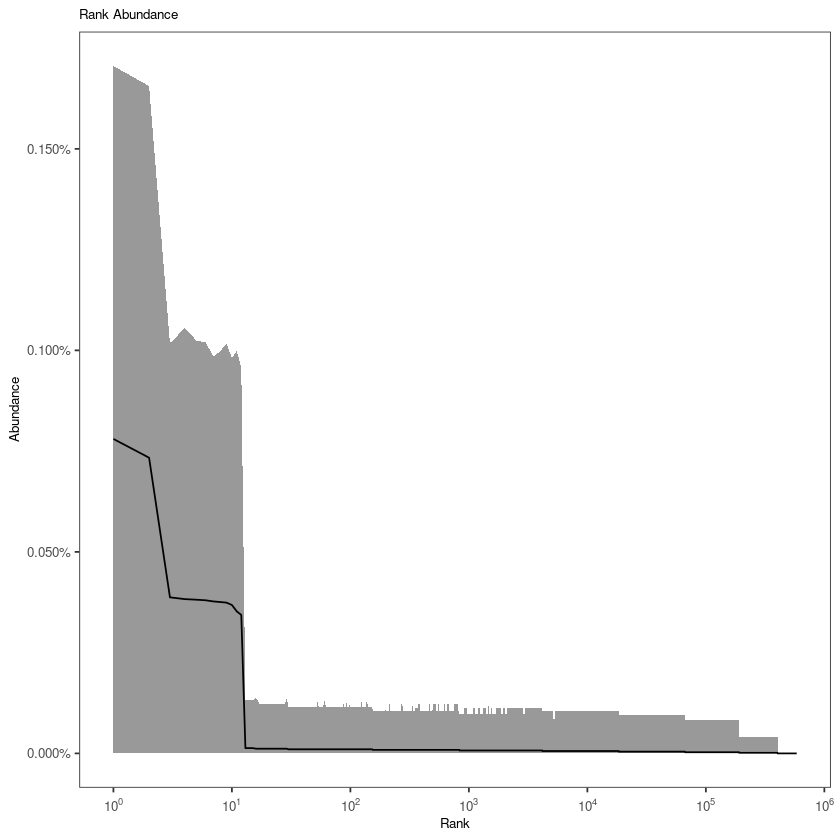

In [35]:
# Calculate rank-abundance curve
a <- estimateAbundance(db, group="c_call")
plot(a, colors=IG_COLORS)

Warning message in estimateAbundance(data, ci = 0.95, ...):
“Not all groups passed threshold min_n=30. Excluded: IGHA”


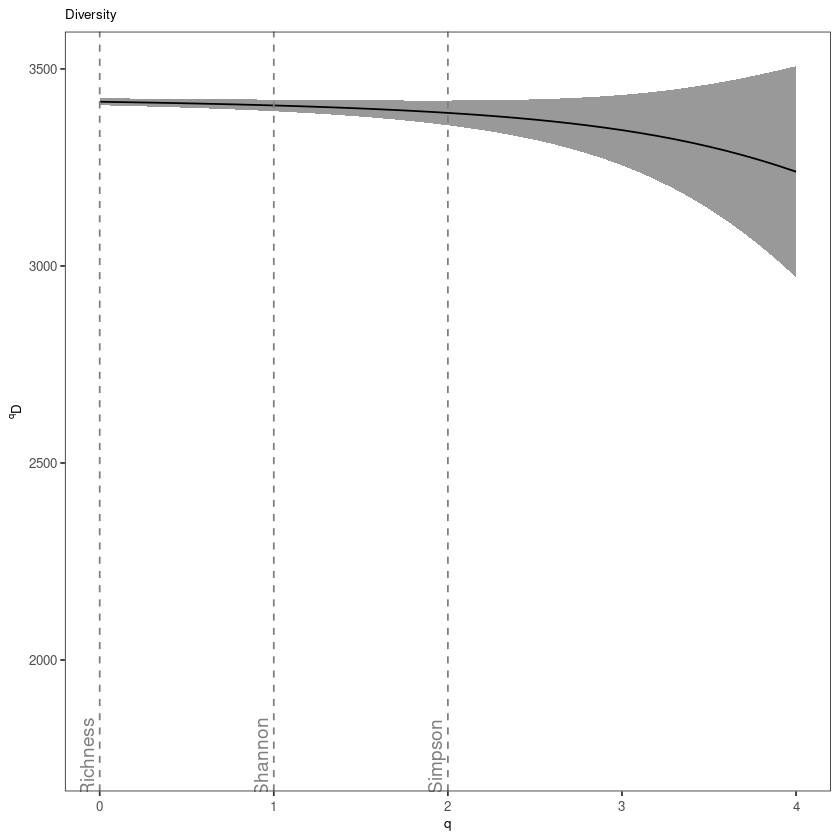

In [36]:
# Generate Hill diversity curve
d <- alphaDiversity(db, group="c_call")
p <- plot(d, silent=T)
p + 
   geom_vline(xintercept=c(0,1,2), color="grey50", linetype="dashed") + 
   geom_text(data=data.frame(q=c(0,1,2), y=round(max(p$data$d_upper)/2), 
             label=c("Richness", "Shannon", "Simpson")), 
             aes(x=q, y=y,label=label), size=4, angle=90, vjust=-0.4, inherit.aes = F, color="grey50")

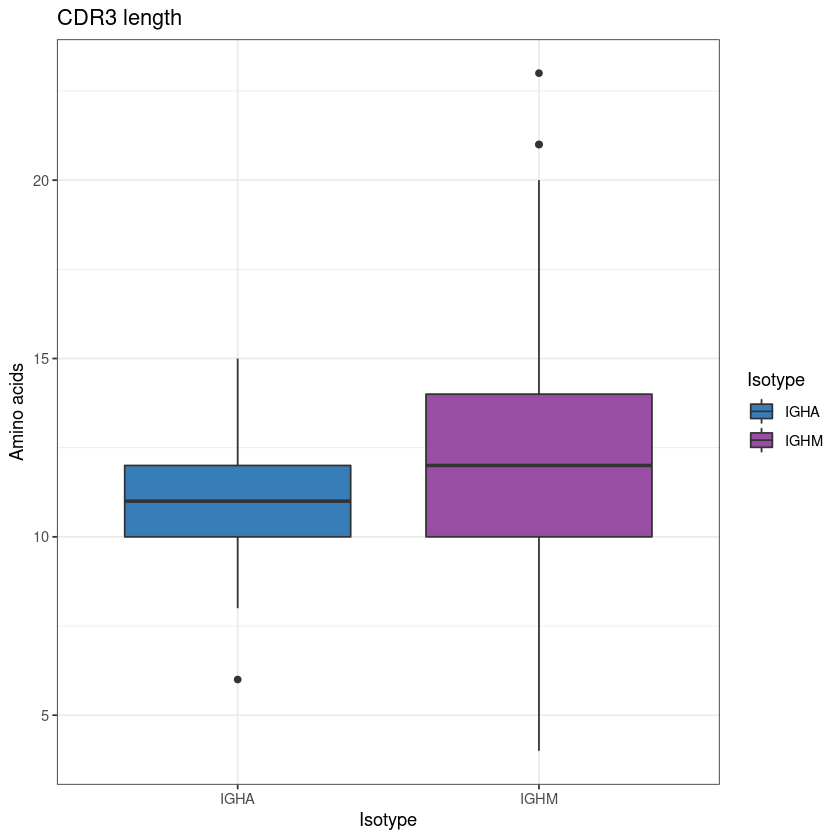

In [37]:
# Calculate CDR3 amino acid properties
db <- aminoAcidProperties(db, seq="junction", nt=T, trim=T, label="cdr3")
# Plot
ggplot(db, aes(x=c_call, y=cdr3_aa_length)) + theme_bw() +
ggtitle("CDR3 length") + xlab("Isotype") + ylab("Amino acids") +
scale_fill_manual(name="Isotype", values=IG_COLORS) +
geom_boxplot(aes(fill=c_call))

In [38]:
# V family usage by isotype
# "clone" specifies to consider one gene per clone_id,
# the most common gene within each clone
usage_fam_iso <- countGenes(db, gene="v_call", groups="c_call", clone="clone_id", mode="family")
# groups="isotype", then usage by isotype sums 1
usage_fam_iso %>% group_by(c_call) %>% summarize(total=sum(clone_freq))

,c_call,total
,<chr>,<dbl>
1,IGHA,1
2,IGHM,1


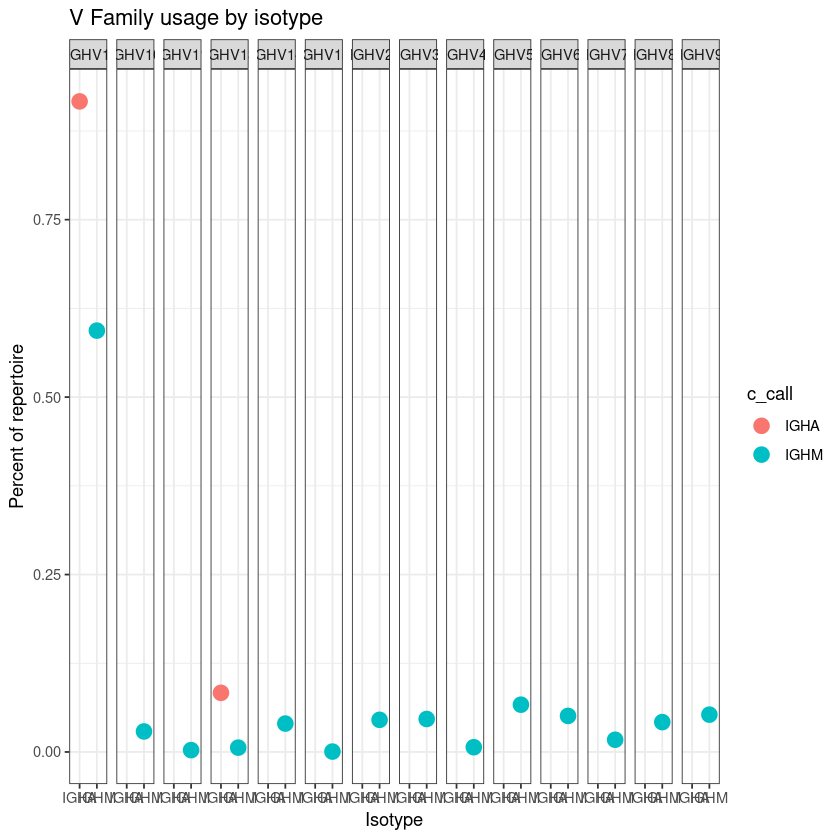

In [39]:
ggplot(usage_fam_iso, aes(x=c_call, y=clone_freq)) + 
geom_point(aes(color=c_call), size=4) +
scale_fill_manual(name="Isotype", values=IG_COLORS) + 
facet_wrap(~gene, nrow=1) +
theme_bw() + ggtitle("V Family usage by isotype") +
ylab("Percent of repertoire") + xlab("Isotype")

In [40]:
# Select one clone, the 2nd largest, just as an example
largest_clone <- countClones(db) %>% slice(2) %>% select(clone_id)
# Subset db, get db with data for largest_clone
db_clone <- subset(db, v_call="v_call", clone_id == largest_clone[['clone_id']])
# Build tree from a single clone
x <- makeChangeoClone(db_clone, text_fields="c_call")

Warning message in buildPhylipLineage(x, phylip_exec = "/usr/local/bin/dnapars"):
“Clone 2847_41 was skipped as it does not contain at least 
                2 unique sequences”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in plot.window(...): need finite 'xlim' values


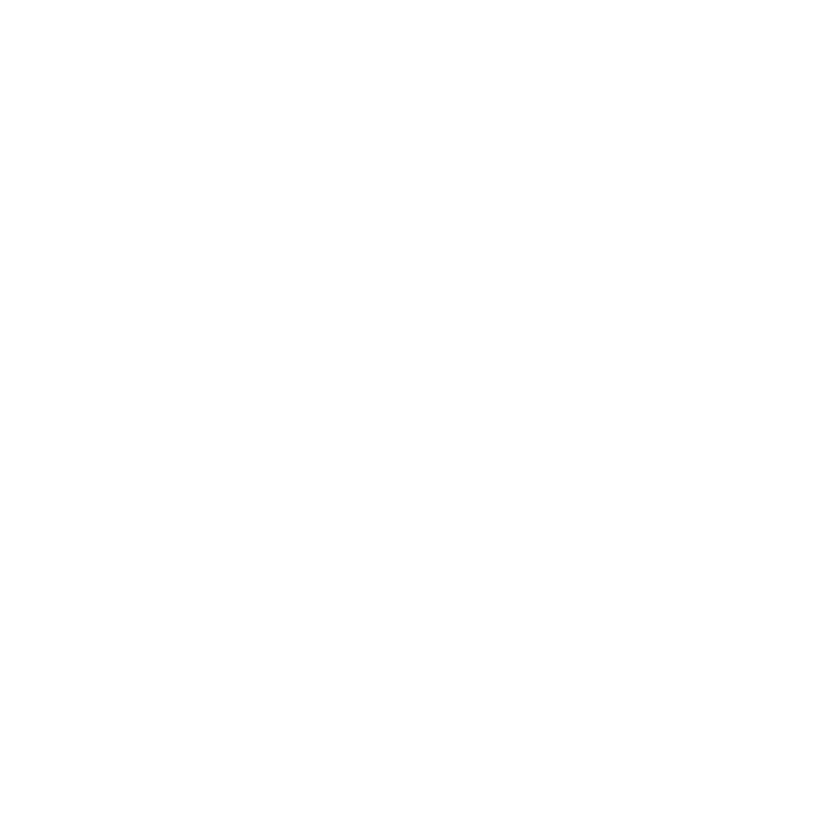

In [41]:
# Lineage reconstruction
g <- buildPhylipLineage(x, phylip_exec="/usr/local/bin/dnapars")
suppressPackageStartupMessages(library(igraph))
plot(g)

Warning message in observedMutations(db, sequenceColumn = "sequence_alignment", :
“Columns mu_count exist and will be overwritten”


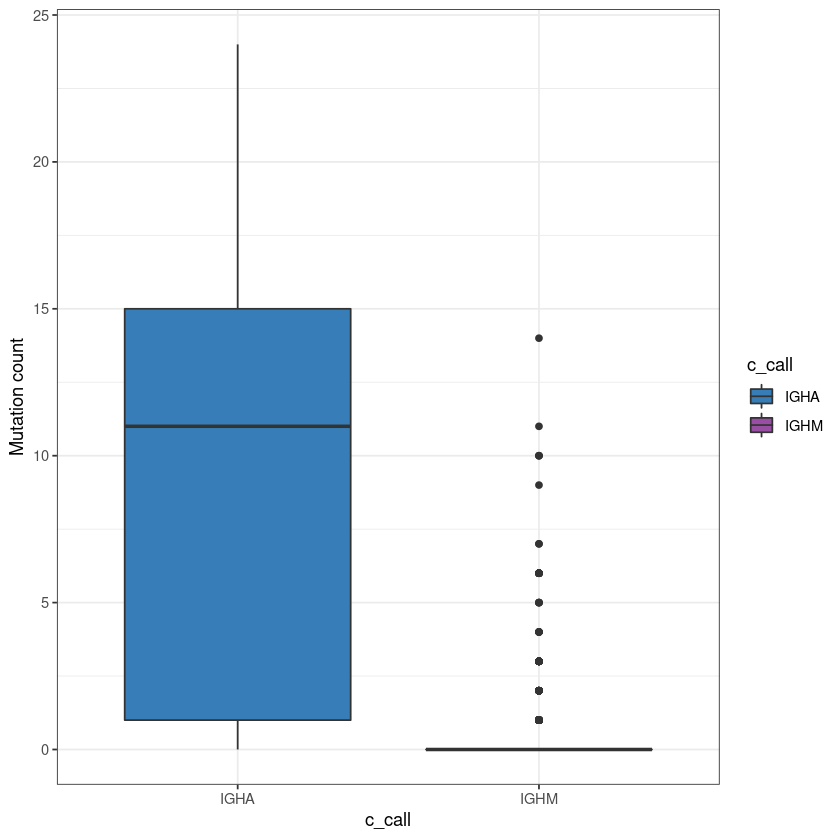

In [44]:
# Calculate total mutation count, R and S combined
db <- observedMutations(db, sequenceColumn="sequence_alignment", 
            germlineColumn="germline_alignment_d_mask",
            regionDefinition=NULL, frequency=F, combine = T, nproc=16)
ggplot(db, aes(x=c_call, y=mu_count, fill=c_call)) +
geom_boxplot() +
scale_fill_manual(name="c_call",values=IG_COLORS) +
xlab("c_call") + ylab("Mutation count") + theme_bw()

Warning message in createMutabilityMatrix(db, sub_mat, model = model, sequenceColumn = sequenceColumn, :
“Insufficient number of mutations to infer some 5-mers. Filled with 0. ”
Warning message:
“Removed 256 rows containing missing values (geom_segment).”
Warning message:
“Removed 256 rows containing missing values (geom_segment).”


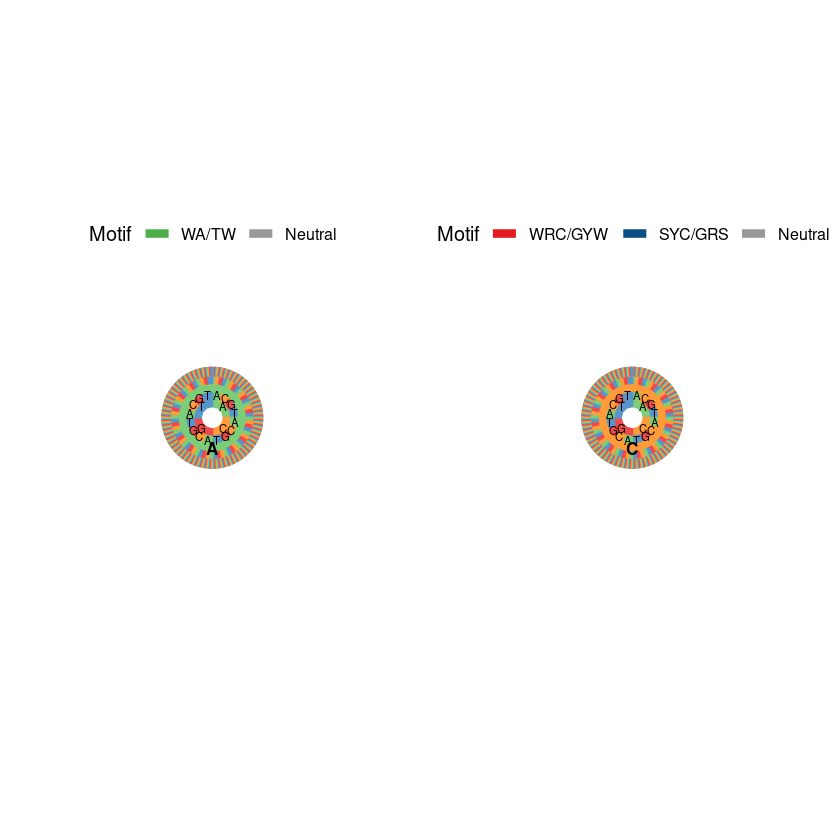

In [45]:
# Build and plot SHM targeting model
m <- createTargetingModel(db, vCallColumn="v_call")
# nucleotides: center nucleotide characters to plot
plotMutability(m, nucleotides=c("A","C"), size=1.2)

calcBaseline will calculate observed and expected mutations for clonal_sequence using clonal_germline as a reference.



Calculating BASELINe probability density functions...
Grouping BASELINe probability density functions...
Calculating BASELINe statistics...


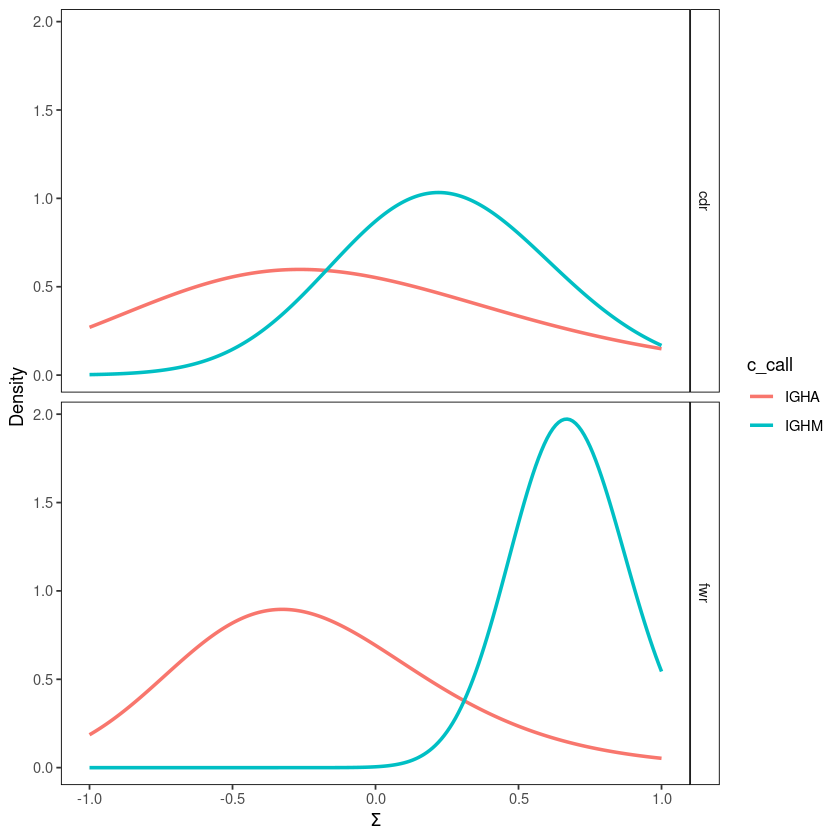

In [46]:
# Calculate clonal consensus and selection using the BASELINe method
z <- collapseClones(db)
b <- calcBaseline(z, regionDefinition=IMGT_V)
# Combine selection scores for all clones in each group
g <- groupBaseline(b, groupBy="c_call")
# Plot probability densities for the selection pressure
plot(g, "c_call", sigmaLimits=c(-1, 1), silent=F)